<a href="https://colab.research.google.com/github/cfernandess/zeroshot_object_detection/blob/main/zeroshot_object_detection_with_owlvit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zero-shot Object Detection for PDF
This demo detects objects within a PDF using a zero-shot object detection model from Hugging Face. It downloads an IKEA manual, converts pages to images, and processes them with the OWLv2 model. Detected objects are highlighted visually, demonstrating efficient identification of key components in instructional documents.


## OWL-ViT: A Quick Intro
OWL-ViT is an open-vocabulary object detector. Given an image and one or multiple free-text queries, it finds objects matching the queries in the image. Unlike traditional object detection models, OWL-ViT is not trained on labeled object datasets and leverages multi-modal representations to perform open-vocabulary detection.

OWL-ViT uses CLIP with a ViT-like Transformer as its backbone to get multi-modal visual and text features. To use CLIP for object detection, OWL-ViT removes the final token pooling layer of the vision model and attaches a lightweight classification and box head to each transformer output token. Open-vocabulary classification is enabled by replacing the fixed classification layer weights with the class-name embeddings obtained from the text model. The authors first train CLIP from scratch and fine-tune it end-to-end with the classification and box heads on standard detection datasets using a bipartite matching loss. One or multiple text queries per image can be used to perform zero-shot text-conditioned object detection.

![owlvit architecture](https://raw.githubusercontent.com/google-research/scenic/a41d24676f64a2158bfcd7cb79b0a87673aa875b/scenic/projects/owl_vit/data/owl_vit_schematic.png)

# Environment


In [ ]:
!pip install -U -q transformers
!pip install -U -q opencv-python
!pip install -U -q matplotlib
!pip install -U -q pdf2image
!apt-get install poppler-utils

# PDF Demo: Zero-shot

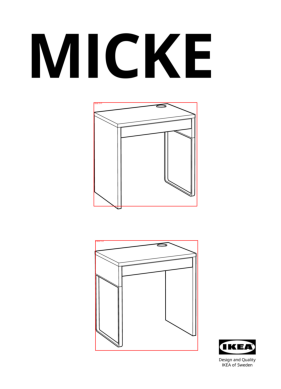

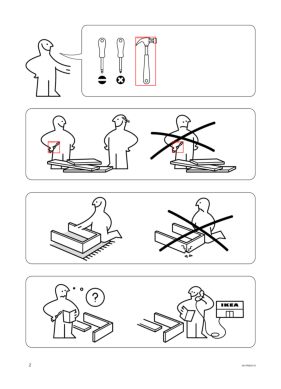

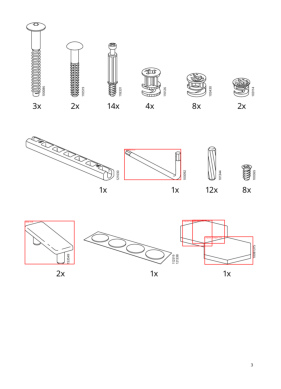

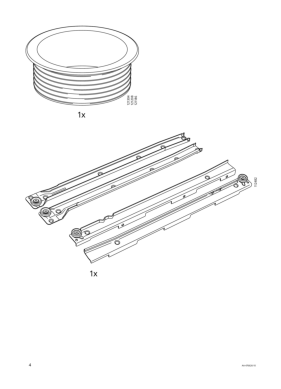

In [18]:
import requests
from PIL import Image, ImageDraw
import torch
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import matplotlib.pyplot as plt
import pdf2image
import numpy as np

def load_model():
    processor = AutoProcessor.from_pretrained("google/owlv2-base-patch16-ensemble")
    model = AutoModelForZeroShotObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")
    return processor, model

def download_pdf(url):
    response = requests.get(url)
    pdf_path = "temp.pdf"
    with open(pdf_path, "wb") as f:
        f.write(response.content)
    return pdf_path

def pdf_to_images(pdf_path):
    return pdf2image.convert_from_path(pdf_path, first_page=1, last_page=4)

def prepare_inputs(processor, images, text_queries):
    # Ensure text queries match the number of images
    if len(text_queries) < len(images):
        text_queries = text_queries * len(images)
    return processor(text=text_queries, images=images, return_tensors="pt")

def get_model_outputs(model, inputs):
    with torch.no_grad():
        return model(**inputs)

def post_process_results(processor, outputs, images, threshold):
    target_sizes = torch.Tensor([image.size[::-1] for image in images])
    return processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=threshold)

def plot_predictions(images, results, text_queries):
    for image_index, (image, result) in enumerate(zip(images, results)):
        draw = ImageDraw.Draw(image)
        text = text_queries[image_index]
        boxes, scores, labels = result["boxes"], result["scores"], result["labels"]

        for box, score, label in zip(boxes, scores, labels):
            box = [round(i, 2) for i in box.tolist()]
            draw.rectangle(box, outline="red", width=3)
            draw.text((box[0], box[1]), f"{text[label]}: {round(score.item(), 2)}", fill="red")

        # Display the image with bounding boxes
        plt.imshow(image)
        plt.axis('off')
        plt.show()

def main():
    # Threshold to eliminate low probability predictions
    score_threshold = 0.25
    # Load model and processor
    processor, model = load_model()

    # Download and convert PDF to images
    pdfs = {
        "MICKE": "https://www.ikea.com/us/en/assembly_instructions/micke-desk-white__AA-476626-10-100.pdf"
    }
    pdf_path = download_pdf(pdfs["MICKE"])
    images = pdf_to_images(pdf_path)

    # Text queries for each page
    text_queries = [
        ["a desk", "a hammer", "a regular hexagon"]
    ]

    # Prepare inputs for all images
    inputs = prepare_inputs(processor, images, text_queries)

    # Get model outputs
    outputs = get_model_outputs(model, inputs)

    # Post-process results
    results = post_process_results(processor, outputs, images, score_threshold)

    # Plot predictions
    plot_predictions(images, results, text_queries * len(images))

# Run the main function
if __name__ == "__main__":
    main()


# PDF Demo: Image-guided Detection

In [ ]:
import requests
from PIL import Image
import torch
from transformers import Owlv2Processor, Owlv2ForObjectDetection
import matplotlib.pyplot as plt
import pdf2image
import cv2
import numpy as np
from matplotlib import rcParams

# Set figure size
%matplotlib inline
rcParams['figure.figsize'] = 11, 8

def load_model():
    processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
    model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")
    return processor, model

def download_pdf(url):
    response = requests.get(url)
    pdf_path = "temp.pdf"
    with open(pdf_path, "wb") as f:
        f.write(response.content)
    return pdf_path

def pdf_to_images(pdf_path, first_page=1, last_page=4):
    images = pdf2image.convert_from_path(pdf_path, first_page=first_page, last_page=last_page)
    resized_images = []
    for image in images:
        image_copy = image.copy()
        image_copy.thumbnail((640, 640), Image.LANCZOS)
        resized_images.append(image_copy)
    return resized_images, images
    return pdf2image.convert_from_path(pdf_path, first_page=first_page, last_page=last_page)

def image_guided_detection(processor, model, resized_images, original_images, query_image_path, score_threshold=0.8):
    # Load the query image
    query_image = Image.open(query_image_path).convert("RGB")
    query_image.thumbnail((640, 640), Image.LANCZOS)
    query_images = [query_image] * len(resized_images)
    # Prepare inputs with query images
    inputs = processor(images=resized_images, query_images=query_images, return_tensors="pt")
    for key, val in inputs.items():
        print(f"{key}: {val.shape}")  # Debug print to check input shapes

    # Perform image-guided detection
    with torch.no_grad():
        outputs = model.image_guided_detection(**inputs)

    # Debug print to check output shapes
    for k, val in outputs.items():
        if k not in {"text_model_output", "vision_model_output"}:
            print(f"{k}: shape of {val.shape}")

    print("Vision model outputs")
    for k, val in outputs.vision_model_output.items():
        print(f"{k}: shape of {val.shape}")

    # Move outputs to CPU
    outputs.logits = outputs.logits.cpu()
    outputs.target_pred_boxes = outputs.target_pred_boxes.cpu()

    # Keep the original size of the images for alignment
    # Remove incorrect reassignment of resized_images
    resized_images = resized_images

    # Post-process results using image-guided detection method for the entire batch
    target_sizes = torch.Tensor([image.size[::-1] for image in original_images])
    results = processor.post_process_image_guided_detection(outputs=outputs, threshold=0.6, nms_threshold=0.3, target_sizes=target_sizes)

    # Convert each image to RGB using OpenCV and draw the bounding boxes
    for i, (original_image, result) in enumerate(zip(original_images, results)):
        img = cv2.cvtColor(np.array(original_image), cv2.COLOR_BGR2RGB)
        boxes, scores = result["boxes"], result["scores"]

        # Sort by scores in descending order
        sorted_indices = torch.argsort(scores, descending=True)
        boxes = boxes[sorted_indices]
        scores = scores[sorted_indices]

        # Limit to top 3 predictions
        boxes = boxes[:3]
        scores = scores[:3]

        # Draw predicted bounding boxes
        for box, score in zip(boxes, scores):
            if score < score_threshold:
                continue
            box = [int(j) for j in box.tolist()]
            img = cv2.rectangle(img, box[:2], box[2:], (255, 0, 0), 5)
            y = box[3] - 10 if box[3] + 25 > 768 else box[3] + 25

        plt.imshow(img[:, :, ::-1])
        plt.axis('off')
        plt.show()



def main():
    # Threshold to eliminate low probability predictions
    score_threshold = 0.9
    # Load model and processor
    processor, model = load_model()

    # Download and convert PDF to images
    pdfs = {
        "MICKE": "https://www.ikea.com/us/en/assembly_instructions/micke-desk-white__AA-476626-10-100.pdf"
    }
    pdf_path = download_pdf(pdfs["MICKE"])
    resized_images, original_images = pdf_to_images(pdf_path)

    # Image-guided detection
    query_image_path = "/content/example.jpg"
    image_guided_detection(processor, model, resized_images, original_images, query_image_path, score_threshold)

# Run the main function
if __name__ == "__main__":
    main()
